## Imports et chargement des retours

In [4]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Si votre structure est mon_projet/notebooks/… alors on monte d’un cran
proj_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if proj_root not in sys.path:
    sys.path.append(proj_root)

# Import des fonctions modulaires
from src.preprocessing import train_test_split_ts
from src.models.garch_models import fit_garch, forecast_garch_var
from src.backtesting import kupiec_test, christoffersen_test

# Charger la série de retours GC=F
returns_file_path = os.path.join("..", "data", "processed", "GC_F_returns.csv")
df_returns_or = pd.read_csv(returns_file_path, parse_dates=["Date"], index_col="Date")
returns_or = df_returns_or["LogReturn"]

## Séparation Train/Test et calibrage GARCH(1,1) Normal

In [5]:
train_or, test_or = train_test_split_ts(returns_or, test_window=250)

print(f"Nombre de jours In‐Sample       : {len(train_or)}")
print(f"Nombre de jours Out‐of‐Sample   : {len(test_or)}")

garch_norm = fit_garch(train_or, p=1, q=1, dist="normal")

#print("\n--- Résumé du GARCH(1,1) Gaussian (In‐Sample) ---")
#print(garch_norm.summary())


Nombre de jours In‐Sample       : 2368
Nombre de jours Out‐of‐Sample   : 250


## Forecast VaR GARCH Normal 95 % (Out‐of‐Sample) et Visualisation Retours vs VaR GARCH Normal 95 %

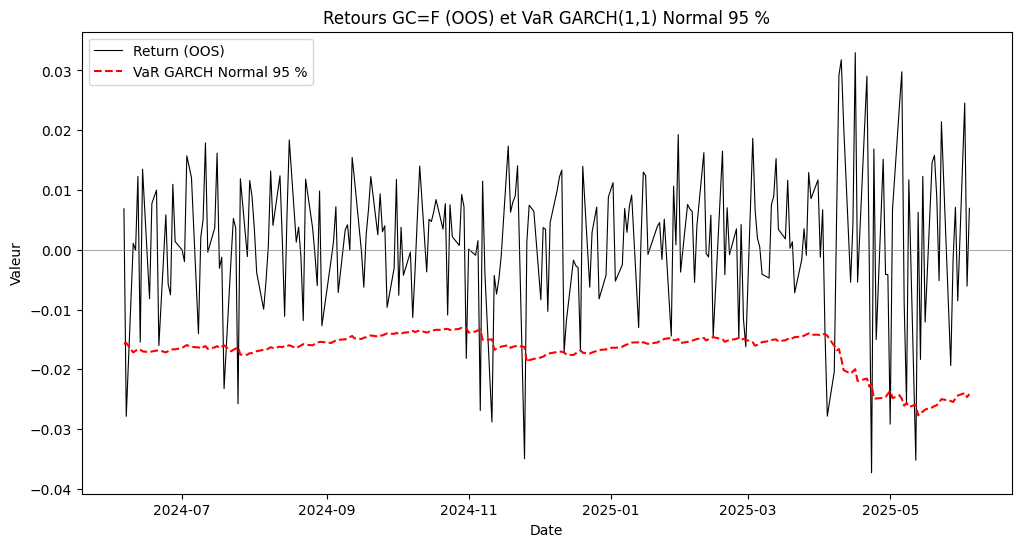

In [6]:
alpha95 = 0.95

# Forecast VaR conditionnelle 95 % pour GARCH Normal
var_garch_norm_95 = forecast_garch_var(
    fitted_res=garch_norm,
    start_dates=test_or.index,
    returns=returns_or,
    alpha=alpha95
)

#print("\nPremières valeurs de VaR GARCH Normal 95 % (OOS) :")
#print(var_garch_norm_95.head())


plt.figure(figsize=(12, 6))
plt.plot(test_or.index, test_or, label="Return (OOS)", color="black", linewidth=0.8)
plt.plot(var_garch_norm_95.index, var_garch_norm_95, label="VaR GARCH Normal 95 %", color="red", linestyle="--")
plt.axhline(0, color="gray", linewidth=0.5)
plt.title("Retours GC=F (OOS) et VaR GARCH(1,1) Normal 95 %")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Valeur")
plt.show()

## Back‐testing Kupiec & Christoffersen pour GARCH Normal 95 %

In [7]:
exceptions_norm_95 = (test_or < var_garch_norm_95).astype(int).values
print('Frequence d exceptions:', exceptions_norm_95.sum()/len(exceptions_norm_95)*100)

lr_kupiec_norm_95, pval_kupiec_norm_95 = kupiec_test(exceptions_norm_95, alpha95)
print("\nKupiec Test pour GARCH Normal 95 % :")
print(f"  LR statistic : {lr_kupiec_norm_95:.2f}, p‐value : {pval_kupiec_norm_95:.4f}")

lr_christ_norm_95, pval_christ_norm_95 = christoffersen_test(exceptions_norm_95)
print("\nChristoffersen Test pour GARCH Normal 95 % :")
print(f"  LR statistic : {lr_christ_norm_95:.2f}, p‐value : {pval_christ_norm_95:.4f}")

Frequence d exceptions: 6.0

Kupiec Test pour GARCH Normal 95 % :
  LR statistic : 0.50, p‐value : 0.4812

Christoffersen Test pour GARCH Normal 95 % :
  LR statistic : 0.01, p‐value : 0.9154


## Calibrage GARCH(1,1) Student‐t (In‐Sample)

In [8]:
garch_student = fit_garch(train_or, p=1, q=1, dist="t")

#print("\n--- Résumé du GARCH(1,1) Student‐t (In‐Sample) ---")
#print(garch_student.summary())

## Forecast VaR GARCH Student‐t 95 % (Out‐of‐Sample)

In [9]:
var_garch_student_95 = forecast_garch_var(
    fitted_res=garch_student,
    start_dates=test_or.index,
    returns=returns_or,
    alpha=alpha95
)
#print("\nPremières valeurs de VaR GARCH Student‐t 95 % (OOS) :")
#print(var_garch_student_95.head())


## Back‐testing Kupiec & Christoffersen pour GARCH Student‐t 95 %

In [10]:
exceptions_student_95 = (test_or < var_garch_student_95).astype(int).values
print('Frequence d exceptions:', exceptions_student_95.sum()/len(exceptions_student_95)*100)

# 2) Kupiec Test
lr_kupiec_student_95, pval_kupiec_student_95 = kupiec_test(exceptions_student_95, alpha95)
print("\nKupiec Test pour GARCH Student 95 % :")
print(f"  LR statistic : {lr_kupiec_student_95:.2f}, p‐value : {pval_kupiec_student_95:.4f}")

# 3) Christoffersen Test
lr_christ_student_95, pval_christ_student_95 = christoffersen_test(exceptions_student_95)
print("\nChristoffersen Test pour GARCH Student 95 % :")
print(f"  LR statistic : {lr_christ_student_95:.2f}, p‐value : {pval_christ_student_95:.4f}")


Frequence d exceptions: 4.3999999999999995

Kupiec Test pour GARCH Student 95 % :
  LR statistic : 0.20, p‐value : 0.6571

Christoffersen Test pour GARCH Student 95 % :
  LR statistic : 0.47, p‐value : 0.4941


## Comparaison graphique Normal vs Student‐t (95 %)

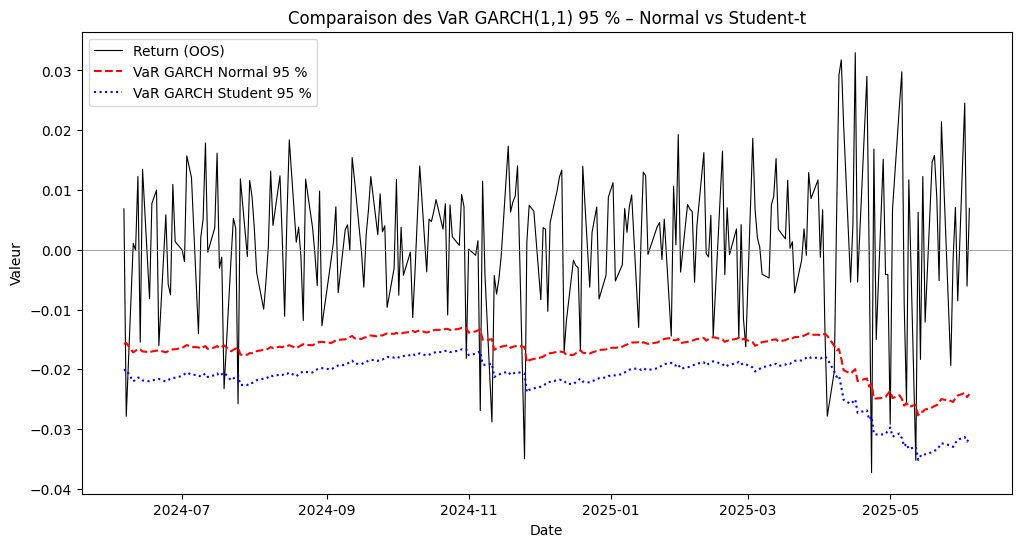

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(test_or.index, test_or, label="Return (OOS)", color="black", linewidth=0.8)

# VaR GARCH Normal 95 %
plt.plot(var_garch_norm_95.index, var_garch_norm_95, label="VaR GARCH Normal 95 %", color="red", linestyle="--")
# VaR GARCH Student‐t 95 %
plt.plot(var_garch_student_95.index, var_garch_student_95, label="VaR GARCH Student 95 %", color="blue", linestyle=":")

plt.axhline(0, color="gray", linewidth=0.5)
plt.title("Comparaison des VaR GARCH(1,1) 95 % – Normal vs Student‐t")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Valeur")
plt.show()

In [12]:
# Forecast VaR GARCH Normal 99 %
alpha99 = 0.99

var_garch_norm_99 = forecast_garch_var(
    fitted_res=garch_norm,
    start_dates=test_or.index,
    returns=returns_or,
    alpha=alpha99
)

# Forecast VaR GARCH Student 99 %
var_garch_student_99 = forecast_garch_var(
    fitted_res=garch_student,
    start_dates=test_or.index,
    returns=returns_or,
    alpha=alpha99
)

print("\nPremières valeurs de VaR GARCH Normal 99 % (OOS) :")
print(var_garch_norm_99.head())

print("\nPremières valeurs de VaR GARCH Student 99 % (OOS) :")
print(var_garch_student_99.head())



Premières valeurs de VaR GARCH Normal 99 % (OOS) :
Date
2024-06-06   -0.022305
2024-06-07   -0.022128
2024-06-10   -0.024347
2024-06-11   -0.023960
2024-06-12   -0.023587
Name: VaR_GARCH_99, dtype: float64

Premières valeurs de VaR GARCH Student 99 % (OOS) :
Date
2024-06-06   -0.035090
2024-06-07   -0.034804
2024-06-10   -0.038311
2024-06-11   -0.037748
2024-06-12   -0.037208
Name: VaR_GARCH_99, dtype: float64


In [15]:
# Back‐testing GARCH Normal 99 %
exceptions_norm_99 = (test_or < var_garch_norm_99).astype(int).values
lr_kupiec_norm_99, pval_kupiec_norm_99 = kupiec_test(exceptions_norm_99, alpha99)
lr_christ_norm_99, pval_christ_norm_99 = christoffersen_test(exceptions_norm_99)

print("\nKupiec Test pour GARCH Normal 99 % :")
print(f"  LR statistic : {lr_kupiec_norm_99:.2f}, p-value : {pval_kupiec_norm_99:.4f}")
print("Christoffersen Test pour GARCH Normal 99 % :")
print(f"  LR statistic : {lr_christ_norm_99:.2f}, p-value : {pval_christ_norm_99:.4f}")

# Back‐testing GARCH Student 99 %
exceptions_student_99 = (test_or < var_garch_student_99).astype(int).values
lr_kupiec_student_99, pval_kupiec_student_99 = kupiec_test(exceptions_student_99, alpha99)
lr_christ_student_99, pval_christ_student_99 = christoffersen_test(exceptions_student_99)

print("\nKupiec Test pour GARCH Student 99 % :")
print(f"  LR statistic : {lr_kupiec_student_99:.2f}, p-value : {pval_kupiec_student_99:.4f}")
print("Christoffersen Test pour GARCH Student 99 % :")
print(f"  LR statistic : {lr_christ_student_99:.2f}, p-value : {pval_christ_student_99:.4f}")



Kupiec Test pour GARCH Normal 99 % :
  LR statistic : 7.73, p-value : 0.0054
Christoffersen Test pour GARCH Normal 99 % :
  LR statistic : 0.53, p-value : 0.4661

Kupiec Test pour GARCH Student 99 % :
  LR statistic : 5.03, p-value : 0.0250
Christoffersen Test pour GARCH Student 99 % :
  LR statistic : 0.00, p-value : 1.0000


## Back‐testing Kupiec & Christoffersen pour GARCH Student‐t 95 %

In [16]:
import pandas as pd

# Rassembler les statistiques dans un DataFrame
results = {
    "Modèle": [
        "GARCH Normal 95 %",
        "GARCH Student 95 %",
        "GARCH Normal 99 %",
        "GARCH Student 99 %"
    ],
    "Kupiec LR": [
        lr_kupiec_norm_95,
        lr_kupiec_student_95,
        lr_kupiec_norm_99,
        lr_kupiec_student_99
    ],
    "Kupiec p-value": [
        pval_kupiec_norm_95,
        pval_kupiec_student_95,
        pval_kupiec_norm_99,
        pval_kupiec_student_99
    ],
    "Christoffersen LR": [
        lr_christ_norm_95,
        lr_christ_student_95,
        lr_christ_norm_99,
        lr_christ_student_99
    ],
    "Christoffersen p-value": [
        pval_christ_norm_95,
        pval_christ_student_95,
        pval_christ_norm_99,
        pval_christ_student_99
    ]
}

df_backtest_summary = pd.DataFrame(results)
df_backtest_summary

,Modèle,Kupiec LR,Kupiec p-value,Christoffersen LR,Christoffersen p-value
0,GARCH Normal 95 %,0.496055,0.481239,0.011297,0.915353
1,GARCH Student 95 %,0.197120,0.657056,0.467480,0.494149
2,GARCH Normal 99 %,7.733551,0.005420,0.531218,0.466095
3,GARCH Student 99 %,5.025168,0.024982,0.000000,1.000000


## 95 % vs 99 %

Pour le 95 %, les deux modèles (Normal et Student-t) sont bien calibrés : les p-values du test de Kupiec sont supérieures à 5 %, donc la proportion d’exceptions observée est proche de 5 %. Pour le 99 %, aucun des deux modèles ne satisfait le test de Kupiec (p-values < 0,05). Cela veut dire que, sur votre fenêtre Out‐of‐Sample, il y a trop ou trop peu de violations par rapport au 1 % attendu. Comme on a généralement plus de violations quand on sous-estime le risque extrême, cela indique que même l’hypothèse Student-t n’est pas suffisamment prudente lorsque l’on va chercher le niveau 99 %.

**Normal vs Student-t en 95 %**

Les deux p-values Kupiec (≈ 0,48 pour Normal ; ≈ 0,66 pour Student-t) sont suffisamment élevées. Le Student-t est un tout petit peu plus conservateur (p-value plus haute) mais dans les deux cas l’écart n’est pas significatif. Pour la 95 %, vos deux VaR (rouge et bleue sur le graphique) fonctionnent.

**Test de Christoffersen**

Dans TOUS les cas (95 ou 99, Normal ou Student-t), la p-value Christoffersen est élevée (> 0,05). Cela signifie qu’il n’y a pas de clustering important d’exceptions : quand elles surviennent, elles semblent arriver de façon indépendante dans le temps. Du point de vue de la dépendance temporelle, le GARCH capture assez bien la dynamique des extrêmes pour que les violations ne soient pas regroupées.